In [251]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [252]:
%pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [253]:
from wordcloud import WordCloud, STOPWORDS

In [254]:
def make_wordcloud(df, column_name):
    
    text = ' '.join(df[column_name].values)
    
    exclude = [
        'using',
        'CMS',
        'open',
        'data',
        'end',
        'collider',
        'event',
        'TeV'
    ]

    stopwords = set(STOPWORDS)

    for e in exclude:
        stopwords.add(e)
    
    wc = WordCloud(
        background_color='white',
        stopwords=stopwords,
    ).generate(titles)
    
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [255]:
def process_dataframe(input_json):
    
    exclude_names = [
        'McCauley',
        'Bellis',
        'Lange',
        'Clemens',
        'Tibor',
        'Šimko',
        'Carerra',
        'Geiser',
        'Lassila-Perini',
        'Dallmeier-Tiessen',
        'Calderon',
        'Rao',
        'Socher',
        'Carrera',
        'Herterich'
    ]
    
    df = pd.read_json(input_json)
    
    '''
    Adds a new column where each row is a list of names from exclude_names 
    that match (substring) those in the author list contained in the authors column
    '''
    df['exclude'] = df['authors'].map(lambda x: [e for e in exclude_names if any(e in xn for xn in x)])
    
    '''
    Filter out rows in-place where there are matches from the
    excluded names
    '''
    df = df[df['exclude'].str.len() == 0]
    
    '''
    Reorder the rows by date and reorder the indices. 
    Then add an index column.
    '''
    df.sort_values(by='date', inplace=True)
    df.reset_index(drop='True', inplace=True)
    df.reset_index(inplace=True)
    
    '''
    Format date
    '''
    df1['date'] = pd.to_datetime(df1['date'], format='%Y-%m-%d')
    
    return df

These papers reference a CMS open data DOI

In [256]:
idf = process_dataframe('data/inspire.json')

Text(0, 0.5, 'Number of papers')

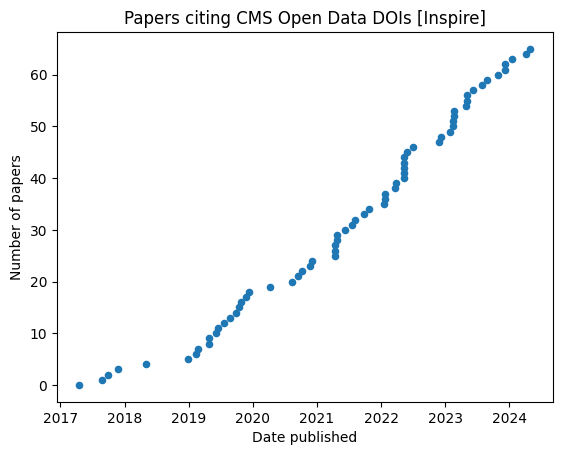

In [267]:
ax = idf.plot(
    kind='scatter',
    x='date', 
    y='index',
    title='Papers citing CMS Open Data DOIs [Inspire]'
)

ax.set_xlabel('Date published')
ax.set_ylabel('Number of papers')

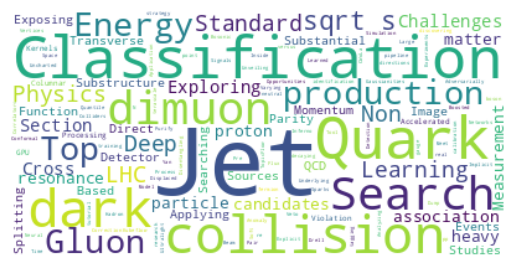

In [268]:
make_wordcloud(idf, 'title')

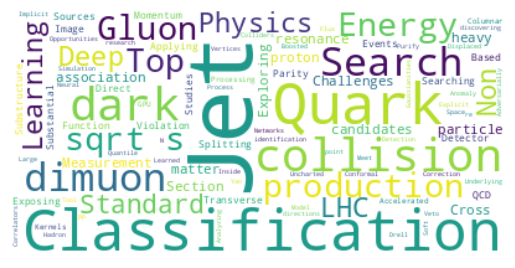

In [269]:
make_wordcloud(idf, 'abstract')

In [270]:
adf = process_dataframe('data/arxiv.json')

Text(0, 0.5, 'Number of papers')

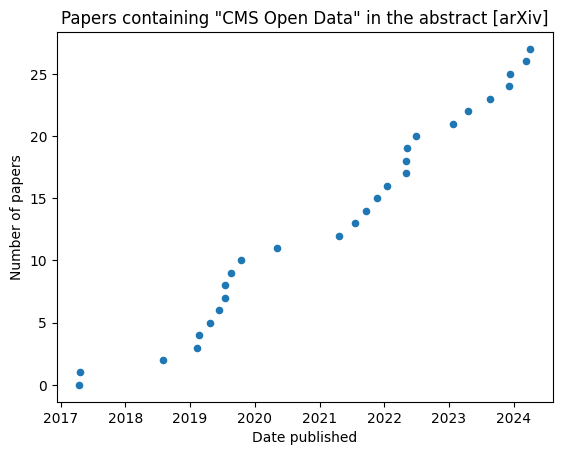

In [272]:
ax = adf.plot(
    kind='scatter',
    x='date', 
    y='index',
    title='Papers containing "CMS Open Data" in the abstract [arXiv]'
)

ax.set_xlabel('Date published')
ax.set_ylabel('Number of papers')

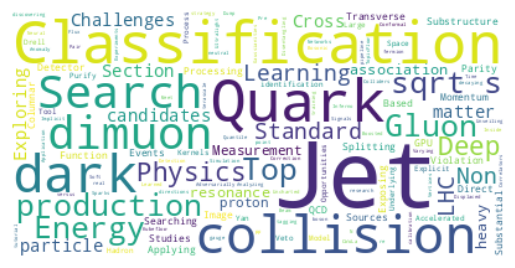

In [273]:
make_wordcloud(adf, 'title')

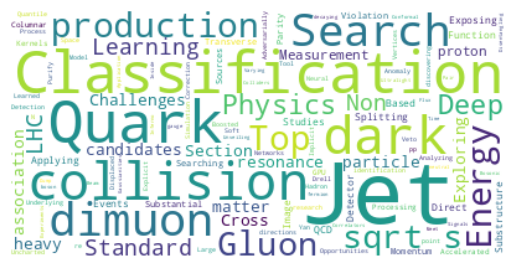

In [274]:
make_wordcloud(adf, 'abstract')